In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter

In [3]:
# Load interaction splits
train_df = pd.read_csv("dataset/interactions_train.csv")
val_df = pd.read_csv("dataset/interactions_validation.csv")
test_df = pd.read_csv("dataset/interactions_test.csv")

# Optional: load raw metadata for future use
raw_recipes = pd.read_csv("dataset/RAW_recipes.csv")
raw_interactions = pd.read_csv("dataset/RAW_interactions.csv")

# Preprocessed embeddings (not needed yet)
pp_users = pd.read_csv("dataset/PP_users.csv")
pp_recipes = pd.read_csv("dataset/PP_recipes.csv")

# Exploratory Data Analysis: Interaction Data

In [4]:
train_df.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


In [12]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698901 entries, 0 to 698900
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    698901 non-null  int64  
 1   recipe_id  698901 non-null  int64  
 2   date       698901 non-null  object 
 3   rating     698901 non-null  float64
 4   u          698901 non-null  int64  
 5   i          698901 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 32.0+ MB


,user_id,recipe_id,rating,u,i
count,6.989010e+05,698901.000000,698901.000000,698901.000000,698901.000000
mean,1.247694e+07,156173.409849,4.574090,4249.330271,87519.330993
std,1.525031e+08,126594.880211,0.959022,5522.602821,51290.370370
min,1.533000e+03,38.000000,0.000000,0.000000,0.000000
25%,1.059880e+05,53169.000000,4.000000,455.000000,42988.000000
50%,2.301020e+05,116484.000000,5.000000,1737.000000,87424.000000
75%,4.801950e+05,234516.000000,5.000000,5919.000000,131731.000000
max,2.002313e+09,537458.000000,5.000000,25075.000000,178262.000000


## Distribution of Recipe Ratings

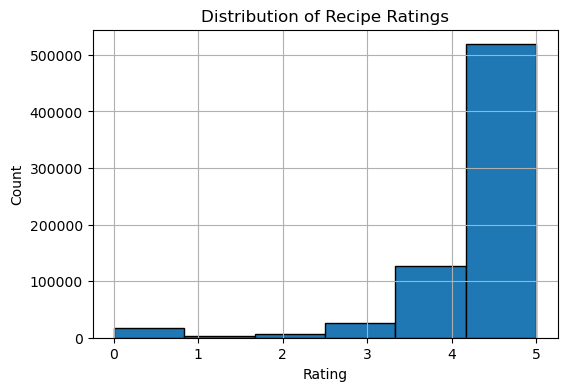

In [15]:
plt.figure(figsize=(6,4))
train_df['rating'].hist(bins=6, edgecolor='black')
plt.title("Distribution of Recipe Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

The distribution of ratings in the dataset is heavily skewed toward the positive end of the scale. Ratings of 4 and 5 stars dominate the dataset, with 5-star ratings forming a noticeable spike. This suggests that users tend to leave high ratings for recipes they try, which is consistent with user behavior on recipe platforms—people often cook recipes they expect to enjoy and are more motivated to provide feedback when the outcome is favorable.

Interestingly, while ratings of 1 and 2 stars are rare, the number of 0-star ratings is noticeably higher than both 1 and 2 stars. In fact, 0-star ratings are closer in frequency to 3-star ratings than to the lower end of the scale. This suggests that users may assign a 0 rating deliberately to express strong dissatisfaction, rather than using intermediate low values like 1 or 2. As a result, the distribution forms a somewhat smooth curve from 1–5, but with a bimodal shape at the extremes: a large concentration at 5 stars, and an unnatural bump at 0.

This behavior has important implications for model design:

- The dominance of high ratings means that predicting the mean rating is not a useful baseline—a trivial model could appear accurate without making meaningful recommendations.

- Because the data is not evenly distributed across the rating scale, metrics like MSE can be misleading.

- Instead, ranking-based evaluation metrics (e.g., Precision@K, Recall@K, MRR) are more appropriate for this dataset, as they focus on how well a model orders preferred recipes rather than how close it gets to numeric ratings.

Overall, this positive and somewhat polarized rating behavior provides a strong motivation for using ranking-based recommender models rather than simple rating prediction approaches.

## Distribution of Ratings per User

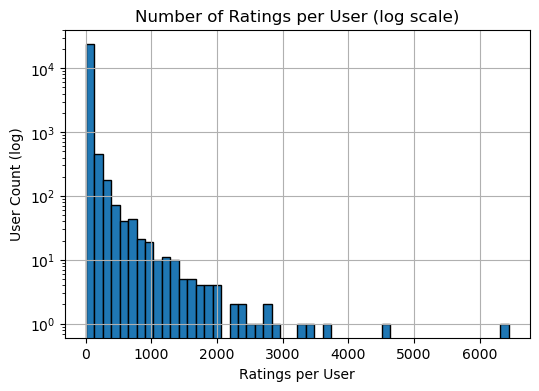

count    25076.000000
mean        27.871311
std        122.729039
min          2.000000
25%          3.000000
50%          6.000000
75%         16.000000
max       6437.000000
dtype: float64

In [29]:
user_counts = train_df.groupby('u').size()

plt.figure(figsize=(6,4))
user_counts.hist(bins=50, log=True, edgecolor='black')
plt.title("Number of Ratings per User (log scale)")
plt.xlabel("Ratings per User")
plt.ylabel("User Count (log)")
plt.show()

user_counts.describe()

The distribution of user activity displays an extreme long-tail pattern. While a small number of users have rated hundreds or even thousands of recipes, the vast majority have contributed only a handful of ratings. This is typical of user-generated content platforms: most users interact casually, whereas a small subset of so-called power users engage extensively.

Because the y-axis is plotted on a logarithmic scale, we can clearly see the steep drop-off in participation. The dataset contains many users who have rated fewer than 10 recipes, and progressively fewer users as the number of ratings increases. Only a tiny fraction exceed 1,000 ratings, and some appear to rate over 6,000 recipes, indicating extremely active contributors.

This imbalance has meaningful implications for model training:

- Sparse user histories make it difficult for the model to learn stable preference patterns for many users.

- Power users may disproportionately influence learned embeddings if the model is not properly regularized.

- Techniques such as latent factor models, which generalize user preferences through shared structure, are well-suited to handle this kind of interaction sparsity.

Overall, the user activity distribution underscores the importance of collaborative approaches that leverage patterns across users, rather than relying solely on individual histories.

## Distribution of Ratings per Recipe

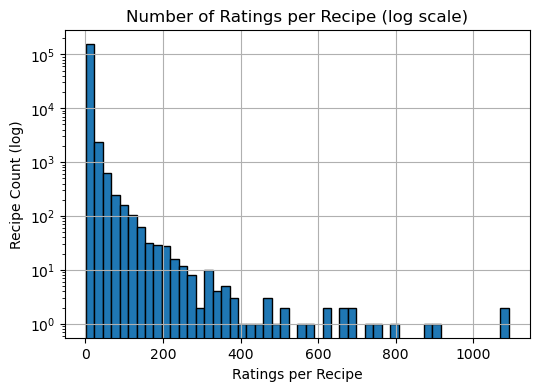

count    160901.000000
mean          4.343671
std          13.421461
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1091.000000
dtype: float64

In [27]:
item_counts = train_df.groupby('i').size()

plt.figure(figsize=(6,4))
item_counts.hist(bins=50, log=True, edgecolor='black')
plt.title("Number of Ratings per Recipe (log scale)")
plt.xlabel("Ratings per Recipe")
plt.ylabel("Recipe Count (log)")
plt.show()

item_counts.describe()

The distribution of recipe popularity shows an even stronger long-tail effect than user activity. Most recipes receive very few ratings, while a small number accumulate hundreds or even over 1,000 ratings. Once again, the use of a logarithmic scale reveals this imbalance clearly: a large proportion of recipes appear only once or twice in the dataset, whereas only a handful receive widespread attention.

This structure is typical of domains with expansive item catalogs, where new or niche items receive little engagement. For recommender systems, this creates a challenge known as the item cold-start problem: many recipes lack enough historical data for the model to learn their characteristics well.

From a modeling standpoint, this motivates the use of techniques that incorporate additional recipe features—such as ingredients, cooking time, tags, or nutritional attributes—to supplement sparse interaction histories. Later extensions to collaborative filtering or factorization models can leverage this metadata to improve recommendations for less frequently rated recipes.

In summary, the long-tail nature of recipe ratings demonstrates both the difficulty and necessity of a recommendation model capable of generalizing from limited item-specific data.

## Sparsity of the Interaction Matrix

In [30]:
n_users = train_df['u'].nunique()
n_items = train_df['i'].nunique()
n_interactions = len(train_df)

sparsity = 1 - n_interactions / (n_users * n_items)
sparsity

0.9998267797514377

The combination of a large number of users, a large number of recipes, and relatively few observed interactions produces an interaction matrix that is extremely sparse. In other words, the vast majority of possible user–recipe pairs have no recorded rating. High sparsity is characteristic of recommendation datasets and directly motivates the use of models such as collaborative filtering and matrix factorization, which exploit shared patterns across users and items to predict missing entries.

# Exploratory Data Analysis: Meta Data

In [9]:
raw_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [10]:
raw_recipes.info()
raw_recipes.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB


,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


## Distribution of Ingredient Counts

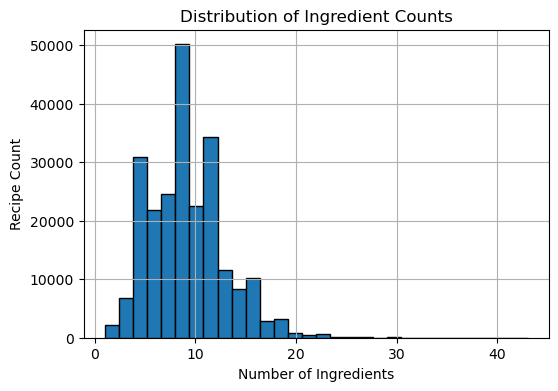

count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

In [8]:
plt.figure(figsize=(6,4))
raw_recipes['n_ingredients'].hist(bins=30, edgecolor='black')
plt.title("Distribution of Ingredient Counts")
plt.xlabel("Number of Ingredients")
plt.ylabel("Recipe Count")
plt.show()

raw_recipes['n_ingredients'].describe()

The number of ingredients per recipe follows a moderately right-skewed distribution. Most recipes require a manageable set of ingredients, with the majority falling between 6 and 11 ingredients. The median of 9 ingredients aligns with this visual impression, suggesting that typical recipes in the dataset are neither overly simple nor excessively complex.

Recipes with fewer than 5 ingredients are relatively uncommon, indicating that most dishes involve a moderate combination of components rather than minimalist, two- or three-ingredient preparations. At the other end of the spectrum, a small number of recipes contain 20 or more ingredients, with the maximum reaching 43, representing highly elaborate dishes that demand substantial preparation and planning.

This distribution provides several useful insights for recommendation strategies:

- The ingredient count reflects a dimension of recipe complexity that may influence user preference. Some users may gravitate toward simple, quick recipes, while others enjoy more involved cooking projects.

- The presence of many recipes clustered around similar ingredient counts suggests room for latent structure in modeling item similarity.

- Given the long tail of high-ingredient recipes, integrating ingredient-based metadata could be valuable for improving recommendations in cold-start contexts for less frequently rated recipes.

Overall, the ingredient counts provide a quantitative lens into recipe complexity and reinforce the potential importance of metadata in augmenting collaborative filtering models.

## Distribution of Cooking Times

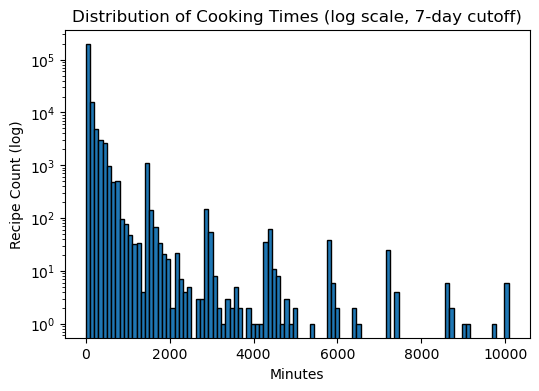

count    230287.000000
mean         81.382219
std         246.600913
min           1.000000
25%          20.000000
50%          40.000000
75%          65.000000
max       10080.000000
Name: minutes, dtype: float64

In [50]:
valid_minutes = raw_recipes['minutes']
valid_minutes = valid_minutes[valid_minutes > 0]  # remove zero-minute anomalies

MAX_REASONABLE_MINUTES = 7 * 24 * 60  # 7 days
valid_minutes = valid_minutes[valid_minutes <= MAX_REASONABLE_MINUTES]

plt.figure(figsize=(6,4))
plt.hist(valid_minutes, bins=100, edgecolor='black', log=True)
plt.title("Distribution of Cooking Times (log scale, 7-day cutoff)")
plt.xlabel("Minutes")
plt.ylabel("Recipe Count (log)")
plt.show()

valid_minutes.describe()

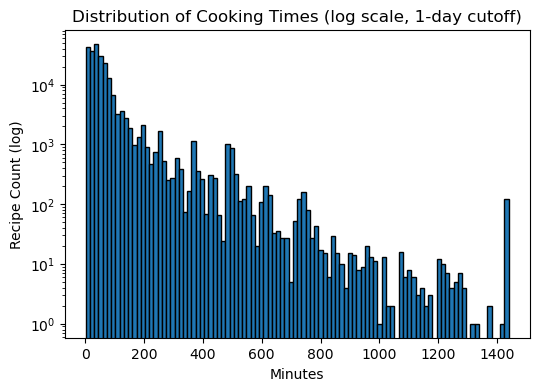

count    228543.000000
mean         65.040933
std         100.741198
min           1.000000
25%          20.000000
50%          40.000000
75%          65.000000
max        1440.000000
Name: minutes, dtype: float64

In [48]:
valid_minutes = raw_recipes['minutes']
valid_minutes = valid_minutes[valid_minutes > 0]  # remove zero-minute anomalies

MAX_REASONABLE_MINUTES = 24 * 60  # 1 day
valid_minutes = valid_minutes[valid_minutes <= MAX_REASONABLE_MINUTES]

plt.figure(figsize=(6,4))
plt.hist(valid_minutes, bins=100, edgecolor='black', log=True)
plt.title("Distribution of Cooking Times (log scale, 1-day cutoff)")
plt.xlabel("Minutes")
plt.ylabel("Recipe Count (log)")
plt.show()

valid_minutes.describe()

The distribution of cooking times exhibits a clear long-tailed structure, with most recipes requiring under an hour to prepare. The median cooking time is 40 minutes, and 75% of recipes complete within 65 minutes, indicating that the dataset is dominated by everyday dishes rather than lengthy, multi-day preparations.

However, the histogram also reveals a striking pattern: distinct spikes at regular time intervals such as 20, 40, 60, 120, 1440, and 2880 minutes. These peaks do not reflect natural variation in cooking durations; instead, they suggest that Food.com's interface offers preset time categories rather than free-form numeric entry. Recipe creators likely selected from options such as "30 minutes or less," "1–2 hours," or "overnight," which the dataset subsequently converted into exact minute values.

This discretization is important for later modeling considerations:

- Cooking time should not be treated as a precise continuous variable

- It is best interpreted as a coarse indicator of recipe effort level

- If used as a feature, it may require binning or embedding, not raw numeric scaling

Overall, the cooking time distribution reinforces the idea that recipe metadata contains interpretable structure, but also highlights the importance of understanding the data collection process behind it.

In [59]:
value_counts = valid_minutes.value_counts().sort_index() 
value_counts.sort_values(ascending=False).head(10)

minutes
30    18391
20    14822
40    13772
25    13204
35    12385
15    12213
45    11517
10    11291
60    10302
50     9929
Name: count, dtype: int64

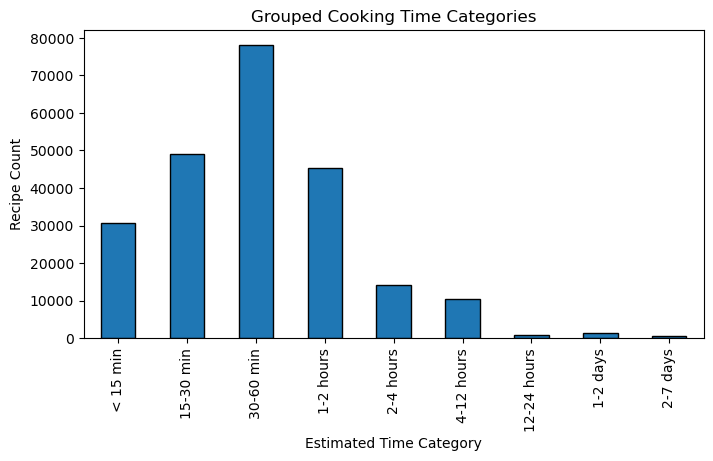

In [54]:
bins = [0, 15, 30, 60, 120, 240, 720, 1440, 2880, 10080]
labels = [
    "< 15 min",
    "15-30 min",
    "30-60 min",
    "1-2 hours",
    "2-4 hours",
    "4-12 hours",
    "12-24 hours",
    "1-2 days",
    "2-7 days"
]

binned = pd.cut(valid_minutes, bins=bins, labels=labels, right=False)
binned.value_counts().sort_index().plot(kind='bar', figsize=(8,4), edgecolor='black')

plt.title("Grouped Cooking Time Categories")
plt.xlabel("Estimated Time Category")
plt.ylabel("Recipe Count")
plt.show()

This confirms that recipe cooking times are not continuous values but fall into a small number of predefined ranges. Rather than reflecting precise preparation durations, the minutes field appears to encode preset time selections from the original interface. This means cooking time should be interpreted as a coarse indicator of effort level rather than an exact numeric measurement, and treated accordingly in any downstream modeling.

## Most Common Recipe Tags

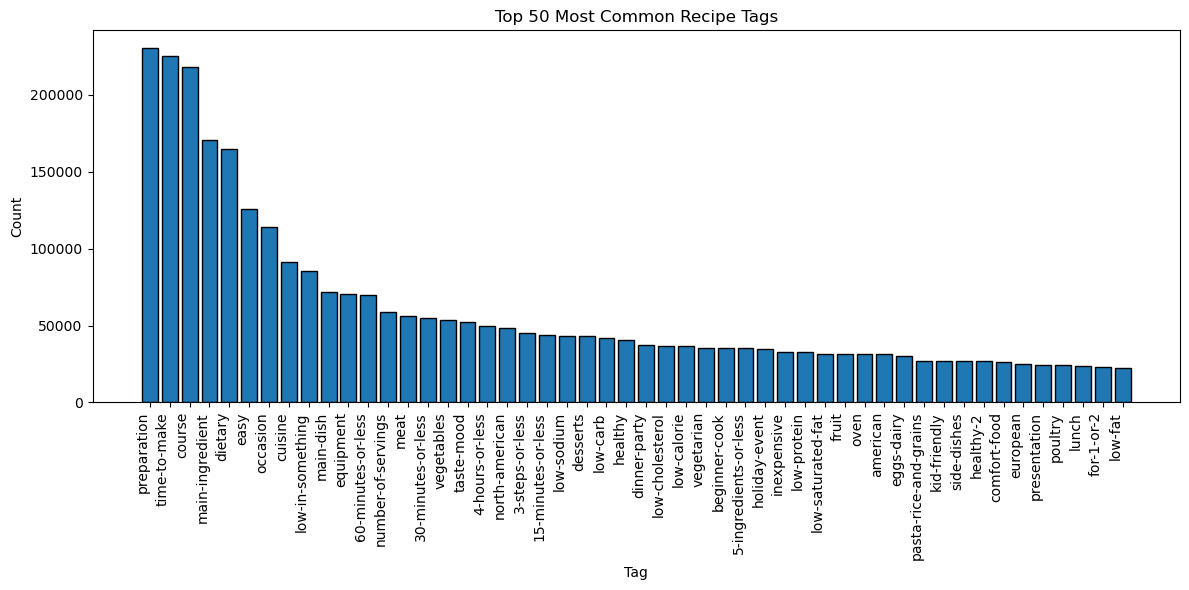

In [67]:
# Convert stringified lists to actual Python lists
raw_tags = raw_recipes['tags'].dropna().apply(ast.literal_eval)

# Flatten the tag lists and count frequencies
tag_counter = Counter(tag for tags in raw_tags for tag in tags)

top_50 = dict(tag_counter.most_common(50))

plt.figure(figsize=(12,6))
plt.bar(top_50.keys(), top_50.values(), edgecolor='black')
plt.xticks(rotation=90, ha='right')
plt.title("Top 50 Most Common Recipe Tags")
plt.ylabel("Count")
plt.xlabel("Tag")
plt.tight_layout()
plt.show()

The top 50 tags reveal that Food.com recipes are annotated with a structured and hierarchical tagging system rather than informal, user-generated keywords. Broad organizational tags such as *preparation*, *time-to-make*, and *course* dominate the dataset, reflecting how the platform categorizes recipes before more specific descriptors like ingredients, cuisines, or dietary restrictions are applied. Time-based tags (e.g., *30-minutes-or-less*, *60-minutes-or-less*) and complexity indicators (e.g., *easy*, *3-steps-or-less*) further reinforce the idea that effort level is central to how users search for and evaluate recipes. Together, these tags provide rich semantic information that can enhance recommendations—especially for new recipes with few ratings—by linking items through shared characteristics.

## Ratings Over Time

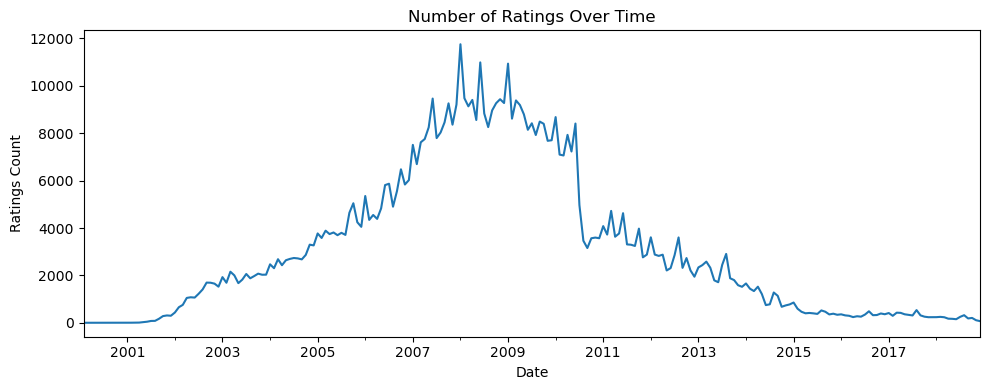

In [ ]:
interactions = train_df.copy()
interactions['date'] = pd.to_datetime(interactions['date'], errors='coerce')

# Aggregate counts by month
ratings_per_month = interactions.groupby(interactions['date'].dt.to_period('M')).size()

plt.figure(figsize=(10,4))
ratings_per_month.plot()
plt.title("Number of Ratings Over Time")
plt.xlabel("Date")
plt.ylabel("Ratings Count")
plt.tight_layout()
plt.show()

ratings_per_month.tail()

The number of ratings submitted to Food.com increased steadily in the early 2000s, surging sharply between 2006 and 2009 before peaking at over 10,000 ratings per month. After 2009, rating activity declined, likely due to users migrating toward newer recipe platforms and social media–driven food communities. This temporal pattern indicates that user engagement is not static—preferences, recipe trends, and platform usage all evolve over time. For a recommender system, this raises the possibility that a time-aware model could outperform a static one by accounting for changes in recipe popularity or shifts in user interests. While our initial models will treat interactions as time-independent, this trend highlights a clear path for future work: incorporating temporal dynamics to personalize recommendations based on when users interact, not just what they interact with.

## Nutritional Distributions

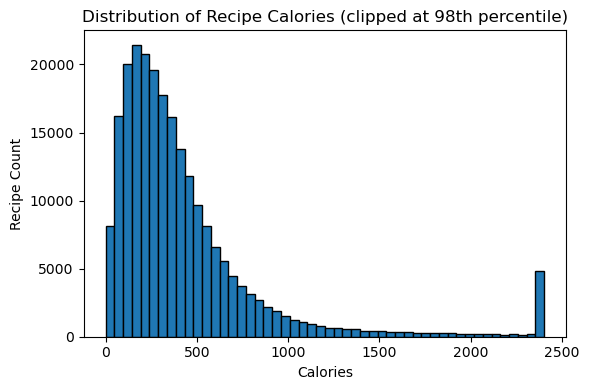

In [85]:
# Parse calories from nutrition column (index 0 in the list)
calories = raw_recipes['nutrition'].dropna().apply(lambda x: ast.literal_eval(x)[0])

# Clip extreme values for readability (95th percentile)
calories_clipped = calories.clip(upper=calories.quantile(0.98))

# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(calories_clipped, bins=50, edgecolor='black')
plt.title("Distribution of Recipe Calories (clipped at 98th percentile)")
plt.xlabel("Calories")
plt.ylabel("Recipe Count")
plt.tight_layout()
plt.show()

The calorie distribution is distinctly right-skewed: most recipes fall between 100 and 500 calories, with progressively fewer high-calorie dishes extending into the 1,000+ calorie range. This reflects the broad range of meals on Food.com, from lighter snacks and sides to calorie-dense entrées and desserts. The shape of this distribution suggests that caloric content is a meaningful differentiator between recipe types and could influence user behavior—some users may consistently prefer lighter dishes, while others gravitate toward more indulgent options. Although our baseline recommender will ignore this information, these nutritional features provide a clear avenue for future extensions, such as health-aware or diet-constrained recommendations that personalize suggestions based not only on past ratings but also on user dietary preferences.